# Breit-Wigner in Jordi's Code

Let's parametrise the Breit-Wigner using Jordi's formulation in numpy and tensorflow

Jordi Garra Tico's amplitude is defined as:

$$
\begin{align*}
BW(m) &= f_R f_D \frac{1}{(m_0^2 - m^2) + i m_0 \Gamma(m)} \Omega\\
\Gamma(m) &= \Gamma_0 \left(\frac{p}{p_0}\right)^3 \frac{m_0}{m} f_R^2 \\
f_R &= \sqrt{\frac{1+R_r^2p_0^2}{1+R_r^2p^2}} \quad \text{with} \quad R_r = 1.5 \\
f_D &= \sqrt{\frac{1+R_D^2 p_{D,0}^2}{1+R_D^2p_D^2}} \quad \text{with} \quad R_D = 5.0 \\
p &= \sqrt{\frac{(m^2-m_A^2-m_B^2)^2 - 4 m_A^2 m_B^2}{4 m^2}}\\
p_R &= \sqrt{\frac{(m_0^2-m_A^2-m_B^2)^2 - 4m_A^2m_B^2}{4 m_0^2}}\\
p_{D,0} &= \sqrt{\frac{(m_D^2-m_0^2-m_C^2)^2 - 4m_0^2m_C^2}{4m_D^2}}\\
p_D &= \sqrt{\frac{(m_D^2-m^2-m_C^2)^2 - 4m^2m_C^2}{4m_D^2}}\\
\Omega &= m_{AC}^2-m_{BC}^2+\frac{(m_D^2-m_C^2)(m_B^2-m_A^2)}{m^2}
\end{align*}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

define the phase-space

In [2]:
# Masses of final state particles
import amplitf.interface as atfi
import amplitf.dynamics as atfd
import amplitf.kinematics as atfk
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
# Dalitz Phase Space
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

2025-05-27 11:43:55.693581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748339035.713661  768362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748339035.720033  768362 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748339035.735814  768362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748339035.735833  768362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748339035.735835  768362 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1748339037.736341  768362 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [3]:
def density_np(a):
    return np.abs(a)**2

def phase_np(a):
    return np.angle(a)

In [4]:
pi180inv = np.pi / 180.

def helicity_np(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = np.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  np.where( spin==2, np.power(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+np.power(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel

def two_body_momentum_np(mAB,mA,mB):
    pAB = (((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB)
    return np.where(pAB>0, np.sqrt(pAB), 0.)

def blatt_weisskopf_np(pR, pAB,radius,spin):
    r2 = radius*radius
    pAB2 = pAB*pAB
    pR2 = pR*pR
    bf= np.where( spin == 1, np.sqrt(1.0+r2*pR*pR)/np.sqrt(1.0+r2*pAB2),
                  np.where( spin == 2, np.sqrt(9.0+3.0*r2*pR2+r2*pR2*r2*pR2)/np.sqrt(9.0+3.0*r2*pAB2+r2*pAB2*r2*pAB2), 
                            1.0) )
    return bf

def amplitude_BW(v1, v2, v3,
                 ampl, phase, gamma, mass, spin,
                 mA, mB, mC, mMother):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=np.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=np.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=np.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    pAB=two_body_momentum_np(mAB, mA, mB)
    pR =two_body_momentum_np(mass, mA, mB)

    pMother=two_body_momentum_np(mMother, mass, mC)
    pDAB=two_body_momentum_np(mMother, mAB, mC)

    # Compute Blatt-Weisskopf barrier factors.
    fR= blatt_weisskopf_np(pR, pAB, R_r, spin)
    fD= blatt_weisskopf_np(pMother, pDAB, R_D, spin)
    power= 2.0*spin+1.0
    
    # Compute the running width.
    gammaAB= gamma*np.power(pAB/pR,power)*(mass/mAB)*fR*fR

    # Compute the amplitude.
    matrixEl = helicity_np(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD/(mass*mass-mAB*mAB-mass*gammaAB*1j)
    matrixEl *= ampl*complex(np.cos(phase*pi180inv),np.sin(phase*pi180inv))

    return matrixEl

Plot BW

In [5]:
nnorm=100000
norm_sample = phsp.uniform_sample(nnorm)
m2ac = phsp.m2ac(norm_sample)
m2ab = phsp.m2ab(norm_sample)
m2bc = phsp.m2bc(norm_sample)
m_ac = np.sqrt(m2ac)
m_ab = np.sqrt(m2ab)
m_bc = np.sqrt(m2bc)

Calculate BW amplitude for $\rho(770)$

In [6]:
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)
srho = atfi.const(lp.rho_770_0.S)
amp_rho = atfi.const(1.0)
ph_rho = atfi.const(0.0)
bw_rho_amp = amplitude_BW(m2ac, m2ab, m2bc,
                 amp_rho.numpy(), ph_rho.numpy(), wrho.numpy(), mrho.numpy(), srho.numpy(),
                 mpi.numpy(), mpi.numpy(), mkz.numpy(), md.numpy())

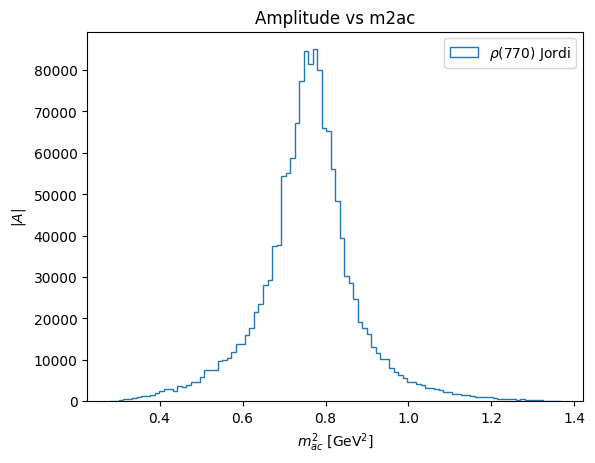

In [7]:
plt.hist(m_ac, weights = density_np(bw_rho_amp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ac')
plt.legend()

AmpliTF Implementation

- test difference in `two_body_momentum`

In [8]:
test = two_body_momentum_np(m_ac, mpi, mpi) - atfk.two_body_momentum(m_ac, mpi, mpi)
print('Difference in two_body_momentum_np and two_body_momentum:', atfi.sum(test))

Difference in two_body_momentum_np and two_body_momentum: tf.Tensor(9.165619652140578e-13, shape=(), dtype=float64)


- test difference in `blatt_weisskopf_ff`

In [9]:
test = blatt_weisskopf_np(two_body_momentum_np(mrho, mpi, mpi), two_body_momentum_np(m_ac, mpi, mpi), 1.5, srho) - \
    atfd.blatt_weisskopf_ff(atfk.two_body_momentum(m_ac, mpi, mpi), atfk.two_body_momentum(mrho, mpi, mpi), atfi.const(1.5), 1)
print('Difference in blatt_weisskopf form factors:', atfi.sum(test))

Difference in blatt_weisskopf form factors: tf.Tensor(1.4895862321395725e-12, shape=(), dtype=float64)


- test difference in helicity distribution

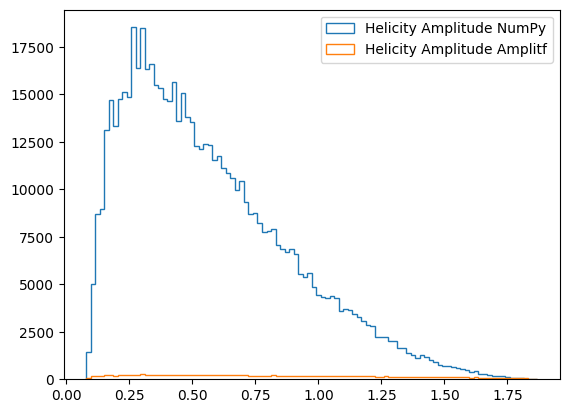

In [10]:
hel_np = helicity_np(m2ac, m2ab, m2bc,
                     mpi.numpy(), mpi.numpy(), mkz.numpy(), md.numpy(), 1)
hel_tf = atfd.helicity_amplitude(phsp.cos_helicity_ac(norm_sample), 1)
plt.hist(m2ac, weights=density_np(hel_np), bins=100, histtype='step', label='Helicity Amplitude NumPy')
plt.hist(m2ac, weights=atfd.density(hel_tf), bins=100, histtype='step', label='Helicity Amplitude Amplitf')
plt.legend()

Jordi's helicity distribution is defined as:
- spin-0: $1$
- spin-1: $m_{AC}^2-m_{BC}^2+\frac{(m_{Mother}^2-m_C^2)(m_B^2-m_A^2)}{m_{AB}^2}$
- spin-2: $\left(m_{BC}^2-m_{AC}^2+\frac{(m_{Mother}^2-m_C^2)(m_A^2-m_B^2)}{m_{AB}^2}\right)^2-
                                    \frac{m_{AB}^2-2(m_{Mother}^2+m_C^2)+(m_{Mother}^2-m_C^2)^2}{3m_{AB}^2}
                                    \frac{m_{AB}^2-2(m_A^2+m_B^2)+(m_A^2-m_B^2)^2}{m_{AB}^2}$


In [11]:
def helicity_tf(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = atfi.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  atfi.where( spin==2, atfi.pow(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+atfi.pow(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+atfi.pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel

Test differences in relativistic BW

In [12]:
def rel_BW_jd_tf(v1, v2, v3,
                 ampl, phase, gamma, mass, spin,
                 mA, mB, mC, mMother, mAAlt=None, mMotherAlt=None):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=atfi.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=atfi.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=atfi.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    p =atfk.two_body_momentum(mAB, mA, mB)
    p0 =atfk.two_body_momentum(mass, mA, mB)

    pDAB=atfk.two_body_momentum(mMother, mAB, mC)
    pMother=atfk.two_body_momentum(mMother if mMotherAlt is None else mMotherAlt, mass, mC)

    # Compute Blatt-Weisskopf barrier factors.
    ffr= atfd.blatt_weisskopf_ff(p, p0, R_r, spin)
    fD= atfd.blatt_weisskopf_ff(pDAB, pMother, R_D, spin)
    
    # Compute the running width.
    gammaAB = atfd.mass_dependent_width(mAB, mass, gamma, p, p0, ffr, spin)

    # Compute the amplitude.
    #matrixEl = atfi.cast_complex(ffr*fD)*atfd.relativistic_breit_wigner(v1,mass,gammaAB)
    #matrixEl *= atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin))
    matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*ffr*fD)/atfi.complex(mass*mass-mAB*mAB,-mass*gammaAB)
    #    matrixEl = atfi.cast_complex(ffr*fD)*atfd.relativistic_breit_wigner(v1,mass,gammaAB)
    #matrixEl = atfd.relativistic_breit_wigner(v1,mass,gammaAB)

    return matrixEl

@atfi.function
def breit_wigner_lineshape(
    m2,
    m0,
    gamma0,
    ma,
    mb,
    mc,
    md,
    dr,
    dd,
    lr,
    ld,
    barrier_factor=True,
    ma0=None,
    md0=None,
):
    m = atfi.sqrt(m2)
    q = atfk.two_body_momentum(md, m, mc)
    q0 = atfk.two_body_momentum(md if md0 is None else md0, m0, mc)
    p = atfk.two_body_momentum(m, ma, mb)
    p0 = atfk.two_body_momentum(m0, ma if ma0 is None else ma0, mb)
    ffr = atfd.blatt_weisskopf_ff(p, p0, dr, lr)
    ffd = atfd.blatt_weisskopf_ff(q, q0, dd, ld)
    width = atfd.mass_dependent_width(m, m0, gamma0, p, p0, ffr, lr)
    bw = atfd.relativistic_breit_wigner(m2, m0, width)  
    ff = ffr * ffd
    if barrier_factor:
        b1 = atfd.orbital_barrier_factor(p, p0, lr)
        b2 = atfd.orbital_barrier_factor(q, q0, ld)
        ff *= b1 * b2
    return bw * atfi.complex(ff, atfi.const(0.0))

In [13]:
bw_rho_shape_tf = breit_wigner_lineshape(m2ac, mrho, wrho, 
                                             mpi, mpi, mkz, md,
                                             1.5, 5.0, 1, 1, barrier_factor=False) * atfi.cast_complex(helicity_tf(m_ac,m_bc,m_ab,mpi,mpi,mkz,md,1))
bw_rho_shape = rel_BW_jd_tf(m2ac, m2ab, m2bc,
                 amp_rho, ph_rho, wrho, mrho, 1,
                 mpi, mpi, mkz, md)#* atfi.cast_complex(helicity_tf(m_ac,m_bc,m_ab,mpi,mpi,mkz,md,1))

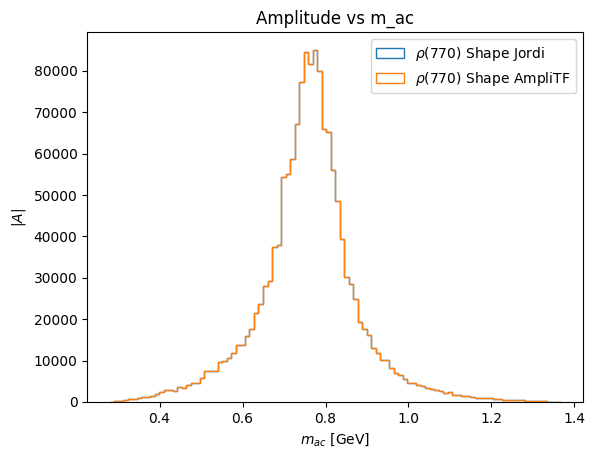

In [14]:
plt.hist(m_ac, weights = density_np(bw_rho_shape), bins=100, histtype='step', label=r'$\rho(770)$ Shape Jordi')
plt.hist(m_ac, weights = atfd.density(bw_rho_shape_tf), bins=100, histtype='step', label=r'$\rho(770)$ Shape AmpliTF')
#plt.hist(m_ac, weights = atfd.density(bw_rho_amp_tf2), bins=100, histtype='step', label=r'$\rho(770)$ AmpliTF2')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ac')
plt.legend()

Let's code the BW the way Jordi did

In [15]:



def amplitude_BW_tf(v1, v2, v3,
                 ampl, phase, gamma, mass, spin,
                 mA, mB, mC, mMother, mAAlt=None, mMotherAlt=None):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=atfi.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=atfi.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=atfi.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    pAB=atfk.two_body_momentum(mAB, mA, mB)
    pR =atfk.two_body_momentum(mass, mA, mB)

    pMother=atfk.two_body_momentum(mMother if mMotherAlt is None else mMotherAlt, mass, mC)
    pDAB=atfk.two_body_momentum(mMother, mAB, mC)

    # Compute Blatt-Weisskopf barrier factors.
    fR= atfd.blatt_weisskopf_ff(pAB, pR, R_r, spin)
    fD= atfd.blatt_weisskopf_ff(pDAB, pMother, R_D, spin)
    
    # Compute the running width.
    gammaAB = atfd.mass_dependent_width(mAB, mass, gamma, pAB, pR, fR, spin)

    # Compute the amplitude.
    #matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD)/atfi.complex(mass*mass-mAB*mAB,-mass*gammaAB)
    matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD)*atfd.relativistic_breit_wigner(v1,mass,gammaAB)
    matrixEl *= atfi.complex(ampl*atfi.cos(phase*pi180inv),ampl*atfi.sin(phase*pi180inv))

    return matrixEl

In [16]:
bw_rho_amp_tf = amplitude_BW_tf(m2ac, m2bc, m2ab,
                 amp_rho, ph_rho, wrho, mrho, 1,
                 mpi, mpi, mkz, md)

In [17]:
bw_rho_amp_tf2 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, 
                                             mpi, mpi, mkz, md,
                                             1.5, 5.0, 1, 1, barrier_factor=False) * \
                atfi.cast_complex(helicity_tf(m_ac,m_bc,m_ab,mpi,mpi,mkz,md,1)) * \
                atfi.complex(amp_rho*atfi.cos(ph_rho*pi180inv),amp_rho*atfi.sin(ph_rho*pi180inv))

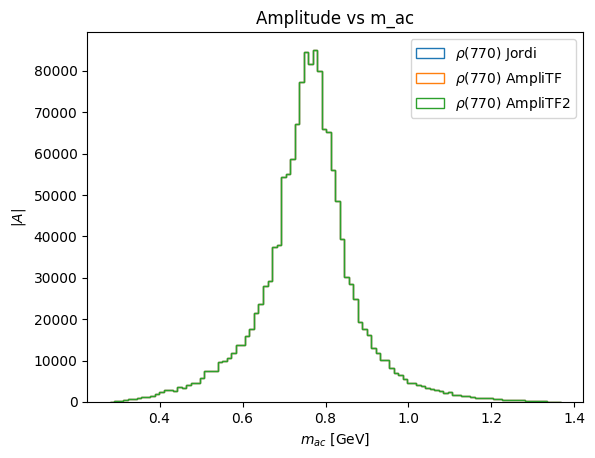

In [18]:
plt.hist(m_ac, weights = density_np(bw_rho_amp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi')
plt.hist(m_ac, weights = atfd.density(bw_rho_amp_tf), bins=100, histtype='step', label=r'$\rho(770)$ AmpliTF')
plt.hist(m_ac, weights = atfd.density(bw_rho_amp_tf2), bins=100, histtype='step', label=r'$\rho(770)$ AmpliTF2')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ac')
plt.legend()

## Jordi's Code

Let's try to import directly the code from Jordi's repo

In [19]:
import ROOT as r
r.gSystem.Load('../../d02kspipi_toys/generator/build/libDalitzJGT.so')

0

In [20]:
ResRho = r.Resonance("BW", 1, 0, mrho.numpy(), wrho.numpy(), 1, 1.5, 5.0, "Y")

Useful to calculate the resonance amplitude

In [21]:
def get_ampBW_cpp(res,x,y,z):
    amp = np.empty(len(x), dtype=complex)
    for i in range(len(x)):
        tmp = res.amplitude_BW(x[i], y[i], z[i])
        amp[i] = complex(tmp.Re(), tmp.Im())
    return amp

def get_amp_cpp(res,x,y):
    amp = np.empty(len(x), dtype=complex)
    for i in range(len(x)):
        tmp = res.contribution(x[i], y[i])
        amp[i] = complex(tmp.Re(), tmp.Im())
    return amp

In [22]:
#bw_rho_amp_cpp = get_ampBW_cpp(ResRho, m2ac, m2ab, m2bc)
bw_rho_amp_cpp = get_amp_cpp(ResRho, m2ab, m2ac)

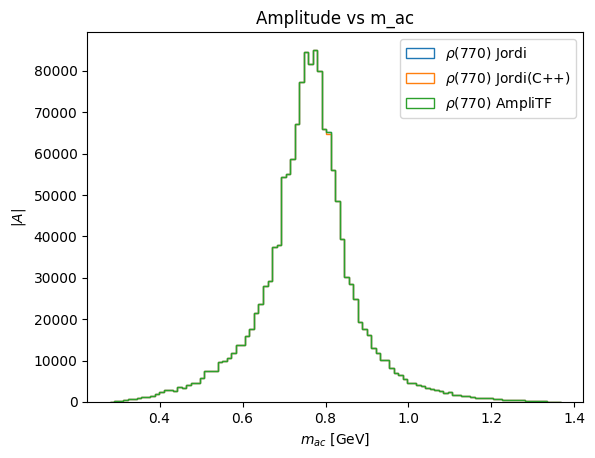

In [23]:
plt.hist(m_ac, weights = density_np(bw_rho_amp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi')
plt.hist(m_ac, weights = density_np(bw_rho_amp_cpp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi(C++)')
plt.hist(m_ac, weights = atfd.density(bw_rho_amp_tf), bins=100, histtype='step', label=r'$\rho(770)$ AmpliTF')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ac')
plt.legend()

In [24]:
#d2kspipi = r.D02KsPiPiAmp()
#d2kspipi.calc_amp(m2ab[0], m2bc[0]) # Kernel crash

Testing $\rho(1450)$ that goes out of phase space

In [25]:
mrho1450 = atfi.const(1.465000000000000)
wrho1450 = atfi.const(0.400000000000000)
c_rho1450 = r.TComplex(2.851309898774982,1.782080113829537)
amp_rho1450 = atfi.const(c_rho1450.Rho())
ph_rho1450 = atfi.const(c_rho1450.Theta() * 180.0 / np.pi)
ResRho_1450 = r.Resonance("BW", amp_rho1450, ph_rho1450, mrho1450, wrho1450, 1, 1.5, 5.0, "Y")

In [26]:
bw_rho1450_amp_cpp = get_amp_cpp(ResRho_1450, m2ab, m2ac)

In [27]:
bw_rho1450_amp_tf = amplitude_BW_tf(m2ac, m2bc, m2ab,
                 amp_rho1450, ph_rho1450, wrho1450, mrho1450, 1,
                 mpi, mpi, mkz, md, mMotherAlt=mrho1450 + mkz)

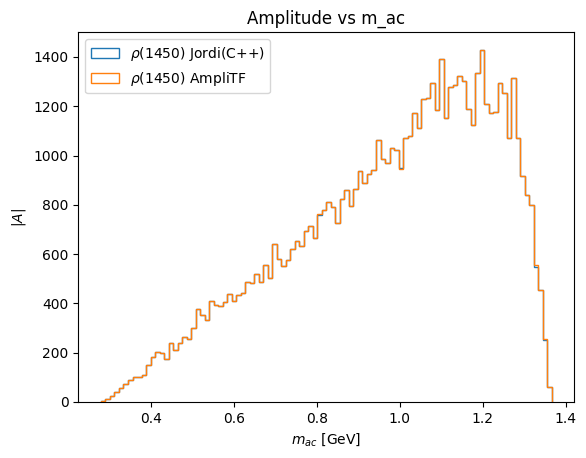

In [28]:
plt.hist(m_ac, weights = density_np(bw_rho1450_amp_cpp), bins=100, histtype='step', label=r'$\rho(1450)$ Jordi(C++)')
plt.hist(m_ac, weights = atfd.density(bw_rho1450_amp_tf), bins=100, histtype='step', label=r'$\rho(1450)$ AmpliTF')
plt.xlabel(r'$m_{ac}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ac')
plt.legend()

Try to combine rho and rho(1450) in the same plot

In [29]:
model_cpp = bw_rho1450_amp_cpp + bw_rho_amp_cpp
model_tf = bw_rho1450_amp_tf + bw_rho_amp_tf

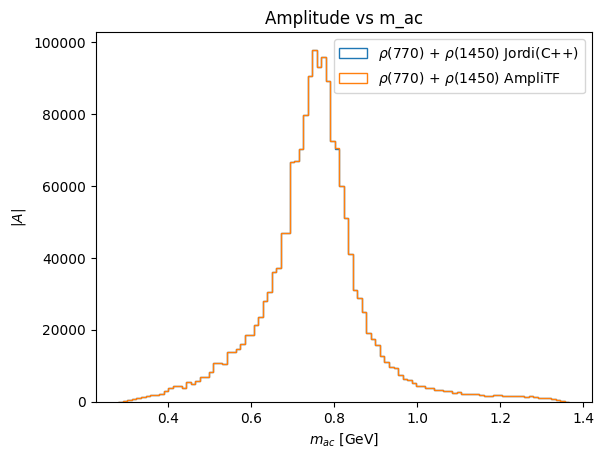

In [30]:
plt.hist(m_ac, weights = density_np(model_cpp), bins=100, histtype='step', label=r'$\rho(770)$ + $\rho(1450)$ Jordi(C++)')
plt.hist(m_ac, weights = atfd.density(model_tf), bins=100, histtype='step', label=r'$\rho(770)$ + $\rho(1450)$ AmpliTF')
plt.xlabel(r'$m_{ac}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ac')
plt.legend()

In [31]:
def plot_argand(x, amps, xlabel=''):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    idx = np.argsort(x)
    for k, amp in amps.items():
        ax[0].hist(x[idx], weights=density_np(amp[idx]), bins=100, histtype='step', label=k)
        ax[1].plot(np.real(amp[idx]), np.imag(amp[idx]), 'o', label=k)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(r'$|A|^2$')
    ax[0].legend()
    ax[1].set_xlabel('Re(A)')
    ax[1].set_ylabel('Im(A)')
    ax[1].set_title('Argand plot')
    ax[1].grid()
    return fig, ax

In [32]:
def plot_amp_ph(x, amps, xlabel=''):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    idx = np.argsort(x)
    for k, amp in amps.items():
        Amp = amp if isinstance(amp, np.ndarray) else amp.numpy()
        ax[0].hist(x[idx], weights=density_np(Amp[idx]), bins=100, histtype='step', label=k)
        ax[1].plot(x[idx], np.angle(Amp[idx]), 'o', label=k)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(r'$|A|^2$')
    ax[0].legend()
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Ph(A)')
    #ax[1].set_title('Argand plot')
    ax[1].grid()
    return fig, ax

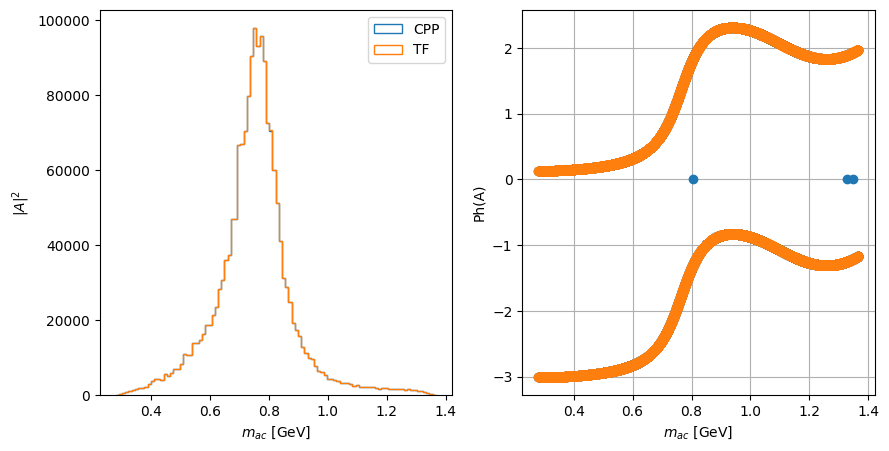

In [33]:
fig, ax = plot_amp_ph(m_ac, {'CPP': model_cpp, 'TF': model_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')

Let's try to add the K*(892) to the plot

In [34]:
mkst = atfi.const(0.893709298220334)
wkst = atfi.const(0.047193287094108)
c_kst = r.TComplex(-1.255025021860793,1.176780750003210)
amp_kst = atfi.const(c_kst.Rho())
ph_kst = atfi.const(c_kst.Theta() * 180.0 / np.pi)
ResKstar = r.Resonance("BW", amp_kst, ph_kst, mkst, wkst, 1, 1.5, 5.0, "X")

In [35]:
bw_kst_amp = amplitude_BW(m2ab, m2bc, m2ac,
                 amp_kst.numpy(), ph_kst.numpy(), wkst.numpy(), mkst.numpy(), 1,
                 mpi.numpy(), mkz.numpy(), mpi.numpy(), md.numpy())

In [36]:
bw_kst_amp_cpp = get_amp_cpp(ResKstar, m2ab, m2ac)

In [37]:
bw_kst_amp_tf = amplitude_BW_tf(m2ab, m2bc, m2ac,
                 amp_kst, ph_kst, wkst, mkst, 1,
                 mpi, mkz, mpi, md)

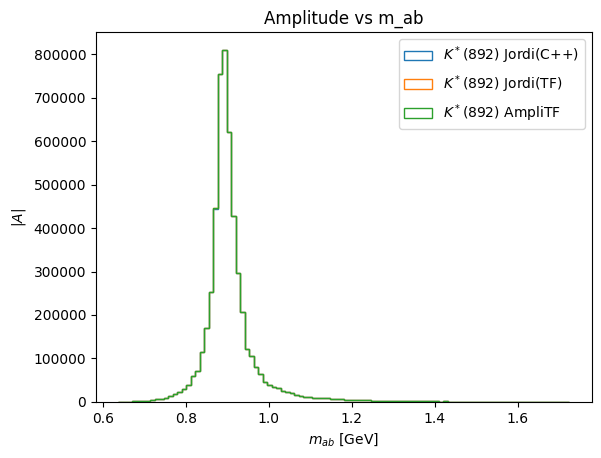

In [38]:
plt.hist(m_ab, weights = density_np(bw_kst_amp_cpp), bins=100, histtype='step', label=r'$K^*(892)$ Jordi(C++)')
plt.hist(m_ab, weights = density_np(bw_kst_amp), bins=100, histtype='step', label=r'$K^*(892)$ Jordi(TF)')
plt.hist(m_ab, weights = atfd.density(bw_kst_amp_tf), bins=100, histtype='step', label=r'$K^*(892)$ AmpliTF')
plt.xlabel(r'$m_{ab}$ [GeV]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m_ab')
plt.legend()

In [39]:
model_cpp = bw_rho1450_amp_cpp + bw_rho_amp_cpp + bw_kst_amp_cpp
model_tf = bw_rho1450_amp_tf + bw_rho_amp_tf + bw_kst_amp_tf
#model_cpp = bw_rho_amp_cpp + bw_kst_amp_cpp
#model_tf = bw_rho_amp_tf + bw_kst_amp_tf

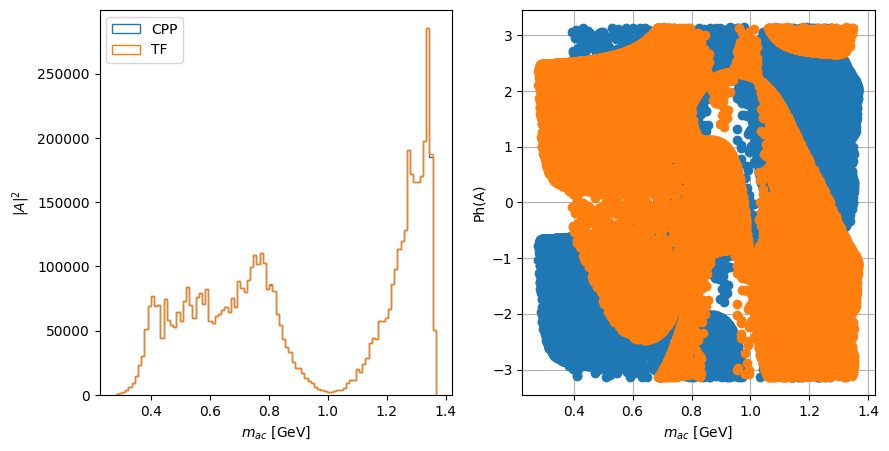

In [40]:
fig, ax = plot_amp_ph(m_ac, {'CPP': model_cpp, 'TF': model_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')

## Try to add the K-matrix and LASS
Things seem to be working, let's try to add the K-matrix and LASS

### K-matrix

In [41]:
# K matrix model parameters
meta = atfi.const(lp.eta.mass/1000.)
metap = atfi.const(lp.etap_958.mass/1000.)
g_poles = atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] )
m_poles = atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] )
b_poles = atfi.complex( atfi.const([3.122415682166643, 11.139907856904129, 29.146102368470210,6.631556203215280,0.0]),
                        atfi.const([7.928823290976309,4.948420661321371,-0.053588781806890,-8.455370251307063,0.0]) )
fprod1 = atfi.complex( atfi.const([-4.724094278696236,-23.289333360304212,-1.860311896516422,-13.638752211193912,0.0]),
                       atfi.const([-6.511009103363590,-12.215597571354197,-32.982507366353126,-22.339804683783186,0.0]) )
fij = atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]])
s0=atfi.const(-3.92637)
K_matrix_sprod = atfi.const(-0.070000000000000)

ResKMatrix = r.Resonance("KMatrix", "Y",
			np.abs(b_poles[0]),
			np.angle(b_poles[0]),
			np.abs(b_poles[1]),
			np.angle(b_poles[1]),
			np.abs(b_poles[2]),
			np.angle(b_poles[2]),
			np.abs(b_poles[3]),
			np.angle(b_poles[3]),
			np.abs(b_poles[4]),
			np.angle(b_poles[4]),
			np.abs(fprod1[0]),
			np.angle(fprod1[0]),
			np.abs(fprod1[1]),
			np.angle(fprod1[1]),
			np.abs(fprod1[2]),
			np.angle(fprod1[2]),
			np.abs(fprod1[3]),
			np.angle(fprod1[3]),
			np.abs(fprod1[4]),
			np.angle(fprod1[4]),
			K_matrix_sprod)

In [42]:
kmatrix_amp_cpp = get_amp_cpp(ResKMatrix, m2ab, m2ac)

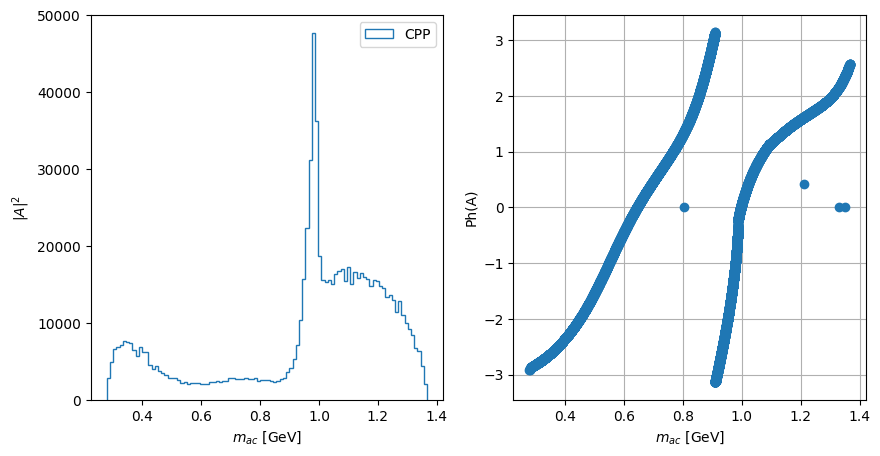

In [43]:
fig, ax = plot_amp_ph(m_ac, {'CPP': kmatrix_amp_cpp},#, 'TF': model_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')

In [44]:
masses_poles = [[atfi.const(mpi), atfi.const(mpi)], 
                [atfi.const(mkz), atfi.const(mkz)], 
                [atfi.const(mpi)], 
                [atfi.const(meta), atfi.const(meta)], 
                [atfi.const(meta), atfi.const(metap)]]

In [45]:
km_belle_tf = atfd.kmatrix_lineshape(m2ac, m_poles, g_poles, s0, fij, b_poles, K_matrix_sprod, fprod1, masses_poles, 1.0, -0.15)

I0000 00:00:1748339295.609038  768571 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x55759a331f00


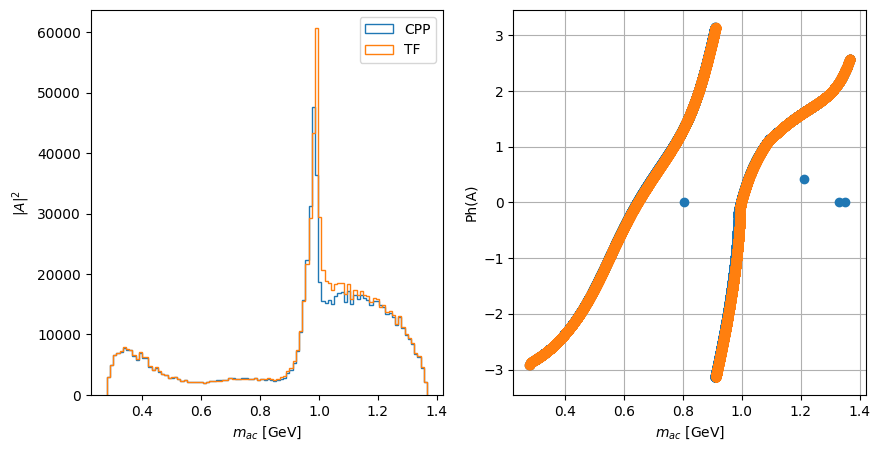

In [46]:
fig, ax = plot_amp_ph(m_ac, {'CPP': kmatrix_amp_cpp, 'TF': km_belle_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')

Add K-matrix to model

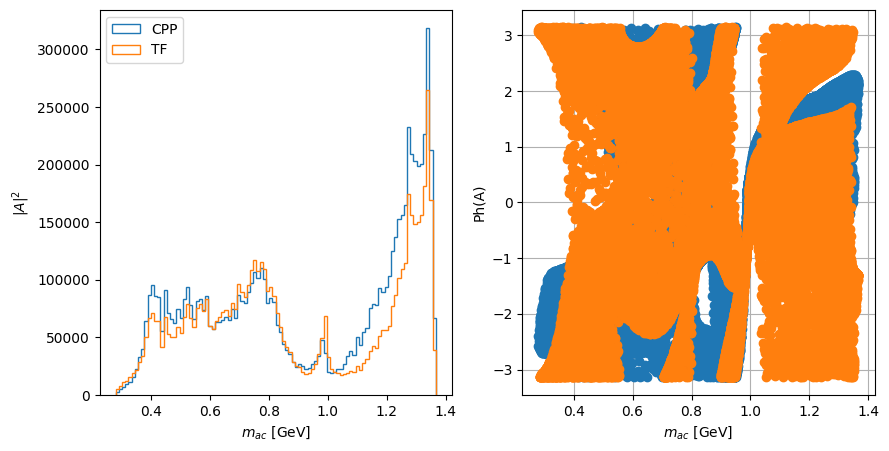

In [47]:
model_cpp = bw_rho1450_amp_cpp + bw_rho_amp_cpp + bw_kst_amp_cpp + kmatrix_amp_cpp
model_tf = bw_rho1450_amp_tf + bw_rho_amp_tf + bw_kst_amp_tf + km_belle_tf
fig, ax = plot_amp_ph(m_ac, {'CPP': model_cpp, 'TF': model_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')

Add LASS to model

In [52]:
# LASS
lass_M = atfi.const(1.4617)
lass_G = atfi.const(0.2683)
lass_F = atfi.const(0.4524)
lass_phiF = atfi.const(0.248)
lass_R = atfi.const(1.0)
lass_phiR = atfi.const(2.495)
lass_a = atfi.const(0.172)
lass_r = atfi.const(-20.6)
#
Kstarzero1430minus = atfi.complex( atfi.const(0.914470111251261), atfi.const(-0.885129049790117) )

In [49]:
def resonant_lass_lineshape(m2ab,
                            m0,
                            gamma0,
                            ma,
                            mb):
    r"""LASS line shape, resonant part

    .. math::

        LASS(m^2) = BW(m^2) (\cos \delta_b + i \sin \delta_b ) ( m_0^2 \Gamma_0 / q_0 )

    Args:
        m2ab (float): invariant mass squared of the system
        m0 (float): resonance mass
        gamma0 (float): resonance width
        a (float): parameter *a* of the effective range term
        r (float): parameter *r* of the effective range term
        md (float): mass of mother particle 
        mc (float): mass of other particle wrt resonance

    Returns:
        complex: the resonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    q0 = atfk.two_body_momentum(m0, ma, mb)
    width = gamma0 * q / m * m0 / q0
    ampl = (atfd.relativistic_breit_wigner(m2ab, m0, width) *
            atfi.cast_complex(m0 * m0 * gamma0 / q0))
    return ampl

def nonresonant_lass_lineshape(m2ab, a, r, ma, mb):
    r"""LASS line shape, nonresonant part

    .. math::

        LASS(m^2) = \frac{m}{q \cot \delta_b - i q}

    
    with :math:`q` is the momentum of the two-body system and :math:`\delta_b` is the scattering phase shift

    .. math::

        \cot \delta_b = \frac{1}{a q} + \frac{1}{2} r q


    from `Aston et al. Nuclear Physics B, Volume 296, Issue 3 (1988), Pages 493-526 <https://doi.org/10.1016/0550-3213(88)90028-4>`_

    Args:
        m2ab (float): invariant mass squared of the system
        a (float): parameter of the effective range term
        r (float): parameter of the effective range term
        ma (float): mass of particle a
        mb (float): mass of particle b

    Returns:
        complex: the nonresonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    # q = atfk.two_body_momentum(m, ma, mb)
    cot_deltab = 1.0 / a / q + 1.0 / 2.0 * r * q
    ampl = atfi.cast_complex(m) / atfi.complex(q * cot_deltab, -q)
    return ampl

def LASS(m2, a, r, m0, gamma0, ma, mb, amp_res, phase_res, amp_nr, phase_nr):
    m = atfi.sqrt(m2)
    #q0 = atfk.two_body_momentum(md, m0, mc)
    q = atfk.two_body_momentum(m, ma, mb)
    cot_delta_beta = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    #delta_beta = atfi.atan(1.0 / cot_delta_beta)
    nr = nonresonant_lass_lineshape(m2, a, r, ma, mb)
    res= resonant_lass_lineshape(m2, m0, gamma0, ma, mb)
    lass = atfi.cast_complex(amp_res) * \
        atfi.complex( atfi.cos(phase_res + 2.0*phase_nr), atfi.sin(phase_res + 2.0*phase_nr) ) * \
             atfi.complex( q * cot_delta_beta, q ) / atfi.complex( q * cot_delta_beta, -q ) * res
    lass += atfi.cast_complex(amp_nr) * atfi.complex( atfi.cos(phase_nr), atfi.sin(phase_nr) ) * \
           atfi.cast_complex( atfi.cos(phase_nr) + atfi.sin(phase_nr) * cot_delta_beta ) * nr
    return lass

In [59]:
ResKstar0_1430 = r.Resonance("LASS", np.abs(Kstarzero1430minus.numpy()), np.angle(Kstarzero1430minus.numpy()) * 180.0 / np.pi, 
                    		 lass_M.numpy(), lass_G.numpy(), 0, 1.5, 5.0, "X",
                             lass_F.numpy(), lass_phiF.numpy(),
							 lass_R.numpy(), lass_phiR.numpy(), 
							 lass_a.numpy(), lass_r.numpy())

In [60]:
lass_kst0_1430_amp_cpp = get_amp_cpp(ResKstar0_1430, m2ab, m2ac)

In [61]:
lass_n = Kstarzero1430minus * LASS(m2ab, lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_phiR, lass_F, lass_phiF)

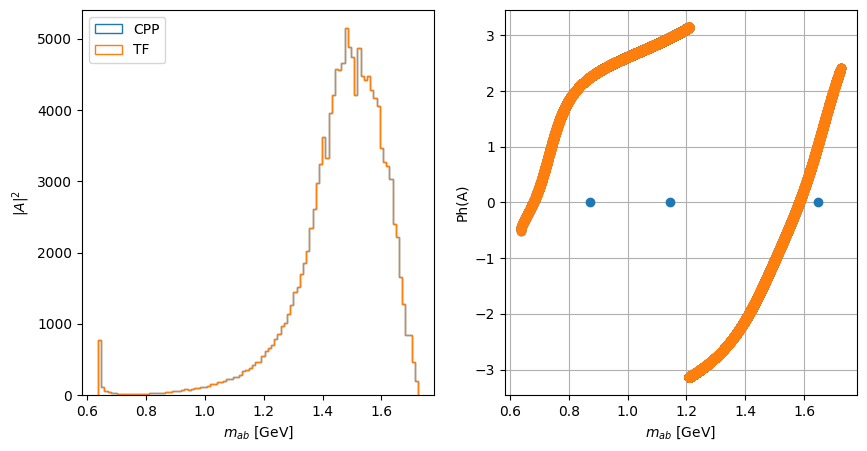

In [62]:
fig, ax = plot_amp_ph(m_ab, {'CPP': lass_kst0_1430_amp_cpp, 'TF': lass_n}, 
                      xlabel=r'$m_{ab}$ [GeV]')

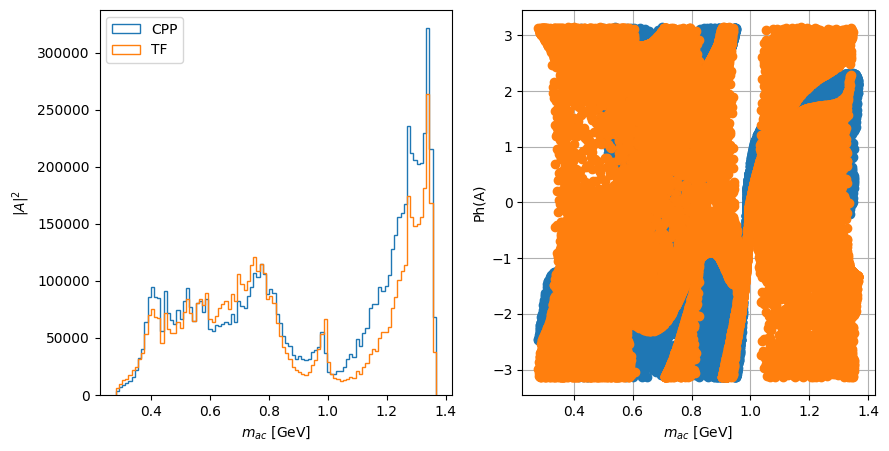

In [63]:
model_cpp = bw_rho1450_amp_cpp + bw_rho_amp_cpp + bw_kst_amp_cpp + kmatrix_amp_cpp + lass_kst0_1430_amp_cpp
model_tf = bw_rho1450_amp_tf + bw_rho_amp_tf + bw_kst_amp_tf + km_belle_tf + lass_n
fig, ax = plot_amp_ph(m_ac, {'CPP': model_cpp, 'TF': model_tf}, 
                      xlabel=r'$m_{ac}$ [GeV]')